- Code taken from https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html


In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time
import os
import copy
import cv2
import pandas as pd

cudnn.benchmark = True
plt.ion() 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

C:\Miniconda\envs\nlp\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
checkpoint = torch.load("../../Models/img_class_ed.pt")
class_names = checkpoint["class_names"]

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))
model_ft.load_state_dict(checkpoint['model_state_dict'])


model_ft = model_ft.to(device)

In [5]:
class ImageDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, data_path,mode,root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.entityds = pd.read_csv(data_path)
        self.root_dir = root_dir
        self.transform = transform
        self.mode = mode

    def __len__(self):
        return len(self.entityds)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.entityds.loc[idx, "Image"])
        image = cv2.imread(img_name)
        if self.transform:
            image = self.transform(image)
        
        labels = -1
        if self.mode != 'test':
            labels = self.entityds.loc[idx, "Labels"]
        #sample = {'image': image, 'entity': labels}

        return image, labels

In [6]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'test': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((256, 256)),
        transforms.CenterCrop((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.4372, 0.4457, 0.4807],[0.3319, 0.3318, 0.3384])
    ]),
}

data_dir = '../Dataset/matchedpairs_finalds.csv'
image_datasets = {x: ImageDataset(data_path=f"../../Dataset/{x}.csv",
                                    mode=x,
                                    root_dir='../../Dataset/images/'
                                    ,transform= data_transforms[x])
                                    for x in ['test']}
                                    
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=0)
              for x in ['test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['test']}

In [8]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
def visualize_model(model, mode='val', num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders[mode]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names.loc[class_names.Labels == preds[j].item(), "LabelName"].values[0]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

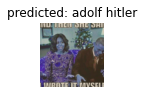

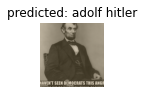

In [12]:
visualize_model(model_ft, "test")

In [10]:
class_names

array(['ku klux klan (kkk)', 'john f. kennedy', 'ted cruz',
       'gary johnson', 'xi jinping', 'kamala harris', 'barack obama',
       'donald trump', 'adolf hitler', 'mitch mcconnell', 'joe biden',
       'bill clinton', 'vladimir putin', 'narendra modi', 'kim jong un',
       'jill stein', 'hillary clinton', 'robert downey jr.',
       'abraham lincoln', 'george bush', 'mike pence', 'dog', 'people',
       'bernie sanders'], dtype=object)